# Assignment Overview

In this assignment, we look at prescriptive analytics to help us make a decision in constructing a portfolio of stocks. To recap the earlier the steps, * We first used descriptive analytics to understand what happened historically in the markets.
* Next, we looked at historical relationships and drivers of the underlying stocks in the market to see whether or not certain features or structures could be revealed using diagnostic analytics
* In the last assignment, we employed ensemble methods to build predictors of future returns

The final prescriptive step is to create an investment recommendation of stocks and the respective amounts to invest in each stock in order to create a portfolio with the:

*   Highest expected return
*   Lowest expected volatility



The ideal way to do this would be to connect the output of the last module and utilize the predicted forward returns and also a forward-looking covariance matrix of all the stocks. (An alternative we could use here would be to plug in the time series forecasts generated by the Prophet package.)

For this assignment, we will take a much simpler path and simply run a portfolio simulation using the historical expected returns and covariance as if they were the forecasted values.

(If you would like to use the outputs from any of the prediction methods, you may do that if you choose. You will need the forecast mean returns and the forecast covariance matrix of the stock returns.)

Using the mean and covariance, you will find the optimal portfolio weights using two different portfolio metrics:

* Sharpe Ratio (Portfolio Return / Portfolio Standard Deviation)
* Minimum Variance Portfolio (or the portfolio with the least risk)

using a simple Monte Carlo simulation of your selected portfolio. All this means is that we will create hypothetical portfolios and select the ones with the optimal characteristics.


The objective of this assignment is to:
* utilize visualization methods for prescriptive analytics
* annotate standard charts
* experiment with simulations in prescriptive analytics

In [ ]:
%load_ext google.colab.data_table

In [ ]:
import pandas as pd
import numpy as np

import plotly.io as pio
pio.templates.default = "plotly_white"

import plotly.express as px
import plotly.graph_objects as go


import pandas_datareader.data as web

## **Homework question 1**

**Choose 4 ticker symbols to create a portfolio**

The selection of the tickers is up to you and should be determined entirely from the visual analyses of the last assignments.

In the ideal case, these 4 tickers have the following properties:
* They have the highest forecasted future returns.
* They have near 0 correlation to one another.

The forecasted returns would ideally have been computed from the last assignment. An alternative would be to rank the forecast returns from the time series prediction using FB's Prophet library. (This is entirely optional.)

The forward-looking covariance estimation is beyond the scope of this class but as a simple programmatic solution. You could compute the covariances for the highest stocks and select the group which has median or mean closest to 0. A domain-based, visual approach would to look at the previous graphs of the covariance of the various sectors and try to choose the 4 stock tickers from the least correlated sectors.

In any case, select any 4 stocks of yor choosing and assign them in the code below.

### Question 1 answer here

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [ ]:
sp_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp_table = sp_data[0]
sp_table

Symbol              Security             GICS Sector  \
0      MMM                    3M             Industrials   
1      AOS           A. O. Smith             Industrials   
2      ABT                Abbott             Health Care   
3     ABBV                AbbVie             Health Care   
4      ACN             Accenture  Information Technology   
..     ...                   ...                     ...   
498    YUM           Yum! Brands  Consumer Discretionary   
499   ZBRA    Zebra Technologies  Information Technology   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   
502    ZTS                Zoetis             Health Care   

                      GICS Sub-Industry    Headquarters Location  Date added  \
0              Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1                     Building Products     Milwaukee, Wisconsin  2017-07-26   
2                 Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                         Biotechnology  North Chicago, Illinois  2012-12-31   
4        IT Consulting & Other Services          Dublin, Ireland  2011-07-06   
..                                  ...                      ...         ...   
498                         Restaurants     Louisville, Kentucky  1997-10-06   
499  Electronic Equipment & Instruments   Lincolnshire, Illinois  2019-12-23   
500               Health Care Equipment          Warsaw, Indiana  2001-08-07   
501                      Regional Banks     Salt Lake City, Utah  2001-06-22   
502                     Pharmaceuticals   Parsippany, New Jersey  2013-06-21   

         CIK      Founded  
0      66740         1902  
1      91142         1916  
2       1800         1888  
3    1551152  2013 (1888)  
4    1467373         1989  
..       ...          ...  
498  1041061         1997  
499   877212         1969  
500  1136869         1927  
501   109380         1873  
502  1555280         1952  

[503 rows x 8 columns]

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yfin
import streamlit as st

yfin.pdr_override()

In [ ]:
# Function to get historical stock prices
def get_historical_prices(tickers, start_date, end_date):
    data = yfin.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

In [ ]:
# Get S&P 500 tickers
sp_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp_table = sp_data[0]
sp_tickers = sp_table['Symbol'].tolist()

# Set start and end dates for historical data
start_date = '2010-01-01'
end_date = '2023-01-01'

# Get historical prices for S&P 500 stocks
sp_prices = get_historical_prices(sp_tickers, start_date, end_date)

# Calculate daily returns
sp_returns = sp_prices.pct_change().dropna()

# Set risk-free rate (you may need to update this based on your context)
risk_free_rate = 0.02

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['KVUE', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1672549200")
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2023-01-01)')
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [ ]:
# calculate Sharpe ratio
sharpe_ratios = (sp_returns.mean() - risk_free_rate) / sp_returns.std()

# Select the top four stocks with the highest Sharpe ratios
best_symbols = sharpe_ratios.sort_values(ascending=False).head(4).index.tolist()

# Show the top four stocks
print("Best 4 Symbols based on Sharpe Ratio:")
print(best_symbols)

Best 4 Symbols based on Sharpe Ratio:
['A', 'AAL', 'AAPL', 'ABBV']


In [ ]:
stock = ['A', 'AAL', 'AAPL', 'ABBV'] # TODO: MODIFY THIS LINE TO USE THE TICKERS YOU SELECTED!!!!


## **Homework question 2**
**In a few sentences, give your justification for using those 4 tickers here based on the analytics from the previous module and include any supporting visualizations (inserting the image directly is suggested)**

### Question 2 answer here

Your answer here

The selection of 'A', 'AAL', 'AAPL', and 'ABBV' as the best 4 symbols is based on their Sharpe Ratio, which is a measure of risk-adjusted performance. A higher Sharpe Ratio implies a better risk-adjusted return. In this case, the selected symbols likely demonstrated a combination of higher average returns and lower volatility compared to other S&P 500 stocks during the given time period.

The scatter plot visualizes the relationship between portfolio risk (standard deviation) and the Sharpe Ratio for the simulated portfolios. The color gradient represents the Sharpe Ratio, where lighter colors indicate higher Sharpe Ratios.



---


Run the following code to pull data for your ticker symbols.
The code:
1. fetches the data
2. computes the simple returns
3. computes the covariance matrix
4. runs a number of simulations of portfolios with random weights
5. stores the simulation results


In [ ]:
import pandas
import numpy as np
from pandas_datareader import data
from datetime import datetime
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [ ]:
from datetime import datetime
data =pdr.get_data_yahoo(stock,start='2010-1-1',end=datetime.today().strftime('%Y-%m-%d'))['Adj Close']
print(data.round(2))

[*********************100%%**********************]  4 of 4 completed
                 A    AAL    AAPL    ABBV
Date                                     
2010-01-04   20.19   4.50    6.48     NaN
2010-01-05   19.97   5.01    6.49     NaN
2010-01-06   19.90   4.80    6.39     NaN
2010-01-07   19.87   4.94    6.38     NaN
2010-01-08   19.87   4.85    6.42     NaN
...            ...    ...     ...     ...
2023-12-08  127.20  13.76  195.71  149.28
2023-12-11  128.97  13.72  193.18  151.24
2023-12-12  128.79  14.04  194.71  153.24
2023-12-13  133.74  14.09  197.96  154.30
2023-12-14  137.96  14.59  198.11  154.88

[3512 rows x 4 columns]


Now we perform some simple calculations using the pandas data manipulation functions.

In [ ]:
stock_ret = data.pct_change()
print(stock_ret.round(4)*100)

               A    AAL  AAPL  ABBV
Date                               
2010-01-04   NaN    NaN   NaN   NaN
2010-01-05 -1.09  11.32  0.17   NaN
2010-01-06 -0.36  -4.14 -1.59   NaN
2010-01-07 -0.13   2.95 -0.18   NaN
2010-01-08 -0.03  -1.91  0.66   NaN
...          ...    ...   ...   ...
2023-12-08 -1.15  -1.08  0.74  0.89
2023-12-11  1.39  -0.29 -1.29  1.31
2023-12-12 -0.14   2.33  0.79  1.32
2023-12-13  3.84   0.36  1.67  0.69
2023-12-14  3.16   3.55  0.08  0.38

[3512 rows x 4 columns]


In [ ]:
#Calculate mean returns and covariances of all of the stocks
mean_returns = stock_ret.mean()
cov_matrix = stock_ret.cov()
print(mean_returns)
print(cov_matrix)

A       0.000712
AAL     0.000864
AAPL    0.001133
ABBV    0.000843
dtype: float64
             A       AAL      AAPL      ABBV
A     0.000328  0.000201  0.000148  0.000104
AAL   0.000201  0.001075  0.000167  0.000094
AAPL  0.000148  0.000167  0.000316  0.000081
ABBV  0.000104  0.000094  0.000081  0.000281


Here we define the simulation parameters.

In [ ]:
#Set the number of iterations to 10000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 10000
simulation_res = np.zeros((3+len(stock),num_iterations))

You will notice that we allocated an empty matrix to hold all of our results. There are many cleaner ways to do this using only pandas objects but this is a numerical approach.

In [ ]:
simulation_res.shape

(7, 10000)

In [ ]:
for i in range(num_iterations):
  #Select random weights and normalize to set the sum to 1
  weights = np.array(np.random.random(len(stock)))
  weights /= np.sum(weights)
  #Calculate the return and standard deviation for every step
  portfolio_return = np.sum(mean_returns * weights)
  portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
  #Store all the results
  simulation_res[0,i] = portfolio_return
  simulation_res[1,i] = portfolio_std_dev
  #Calculate Sharpe ratio and store it in the array
  simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
  #Save the weights in the array
  for j in range(len(weights)):
    simulation_res[j+3,i] = weights[j]

In [ ]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',*stock])
sim_frame


ret     stdev    sharpe         A       AAL      AAPL      ABBV
0     0.000898  0.016360  0.054888  0.179127  0.339555  0.246530  0.234788
1     0.000875  0.014281  0.061268  0.326116  0.182231  0.245079  0.246574
2     0.000937  0.013278  0.070590  0.130762  0.075633  0.379527  0.414078
3     0.000877  0.013923  0.062956  0.396585  0.104671  0.287893  0.210851
4     0.000973  0.014613  0.066558  0.119207  0.184053  0.488038  0.208702
...        ...       ...       ...       ...       ...       ...       ...
9995  0.000961  0.016546  0.058094  0.006132  0.344121  0.386146  0.263600
9996  0.000905  0.015813  0.057221  0.084638  0.320426  0.229020  0.365917
9997  0.000901  0.014953  0.060289  0.453329  0.102714  0.399528  0.044429
9998  0.000903  0.015267  0.059169  0.351239  0.206736  0.352344  0.089681
9999  0.000858  0.017240  0.049746  0.302517  0.368020  0.161183  0.168280

[10000 rows x 7 columns]

Now we can locate the ideal portfolios from the simulation.

In [ ]:
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

In [ ]:
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
print("The portfolio for max Sharpe Ratio:\n",max_sharpe)
print("\nThe portfolio for min risk:\n",min_std)

The portfolio for max Sharpe Ratio:
 ret       0.000998
stdev     0.013758
sharpe    0.072503
A         0.035752
AAL       0.028412
AAPL      0.547505
ABBV      0.388331
Name: 9121, dtype: float64

The portfolio for min risk:
 ret       0.000905
stdev     0.013124
sharpe    0.068951
A         0.236543
AAL       0.030936
AAPL      0.318780
ABBV      0.413740
Name: 8928, dtype: float64


In [ ]:
max_sharpe.stdev

0.013758338074076098

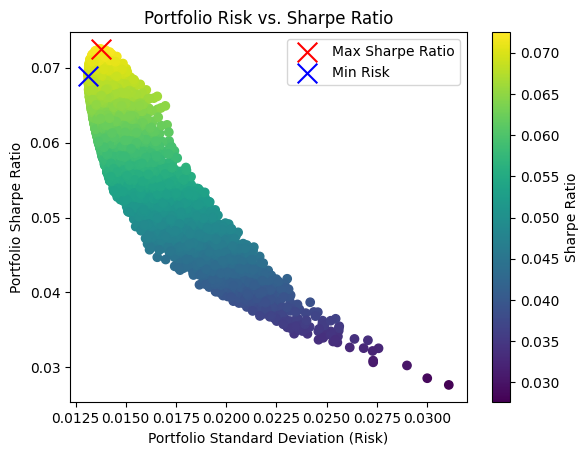

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of the simulated portfolios
plt.scatter(sim_frame['stdev'], sim_frame['sharpe'], c=sim_frame['sharpe'], cmap='viridis', marker='o')
plt.title('Portfolio Risk vs. Sharpe Ratio')
plt.xlabel('Portfolio Standard Deviation (Risk)')
plt.ylabel('Portfolio Sharpe Ratio')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe['stdev'], max_sharpe['sharpe'], marker='x', color='red', s=200, label='Max Sharpe Ratio')
plt.scatter(min_std['stdev'], min_std['sharpe'], marker='x', color='blue', s=200, label='Min Risk')
plt.legend()
plt.show()

## **Homework question 3**

* **Create a scatter plot of all of the portfolios. On the x-axis will be the standard deviation of the portfolio (the stdev column of the dataframe `simframe`). On the y-axis, place the portfolio return (the ret column of `simframe`)**.
* **annotate the graph such that the portfolios corresponding the the minimum standard deviation and the max Sharpe Ratio portfolios are highlighted or labelled.**


#### Question 3 answer here

In [ ]:
# your code here
import plotly.express as px
fig = px.scatter(sim_frame, x = 'stdev', y='ret', color = 'sharpe')


fig.add_annotation(
            x=max_sharpe.stdev,
            y=max_sharpe.ret,
            text="max Sharpe Ratio")
fig.add_annotation(
            x=min_std.stdev,
            y=min_std.ret,
            text="min standard deviation")
fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
))
fig.show()

## Homework question 4

Let's see how an investment in either of the two portfolios would have fared in the last 2 years.

**Create 2 time series visualizations showing the cumulative returns of the portfolios compared to one another.**

### Question 4 answer here

In [ ]:
# Your code for the cumulative returns and respective visualization here
from dateutil.relativedelta import relativedelta


todays_date = datetime.today().strftime('%Y-%m-%d')
two_years_ago_date = (datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d')
price_data = data.loc[two_years_ago_date:todays_date]
ret_data = price_data.pct_change()[1:]




In [ ]:
# Asset weights for max sharpe ratio portfolio
sr_wts = [max_sharpe[x] for x in stock]
sr_weighted_returns = (sr_wts * ret_data)
sr_port_ret = sr_weighted_returns.sum(axis=1)
sr_cumulative_ret = (sr_port_ret + 1).cumprod()

In [ ]:
# Asset weights for max sharpe ratio portfolio
mr_wts = [min_std[x] for x in stock]
mr_weighted_returns = (mr_wts * ret_data)
mr_port_ret = mr_weighted_returns.sum(axis=1)
mr_cumulative_ret = (mr_port_ret + 1).cumprod()

In [ ]:
# Create the cumulative return plots
fig = go.Figure()
fig.add_trace(go.Scatter(x=sr_cumulative_ret.index, y=sr_cumulative_ret,
                    mode='lines',
                    name="Sharpe Ratio Cumulative Return"))
fig.add_trace(go.Scatter(x=mr_cumulative_ret.index, y=mr_cumulative_ret,
                    mode='lines',
                    name="Min. Risk Cumulative Return"))

# Set title
fig.update_layout(
    title_text="Cumulative Returns"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


fig.show()




#### instructor's commnents: Thanks for the excellent work, the graph are neat